In [1]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

In [409]:
import seaborn as sns
import colorcet as cc
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'text.color': "black",
                     'axes.labelcolor': "black"})
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": "--"})
colors = sns.color_palette(cc.CET_CBTL4)


In [410]:
# nice plot templates
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-moon.mplstyle -P /tmp

--2023-05-15 16:05:37--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40906 (40K) [text/plain]
Saving to: ‘/tmp/rose-pine.mplstyle.2’

rose-pine.mplstyle. 100%[===================>]  39,95K  --.-KB/s    in 0,02s   

2023-05-15 16:05:37 (1,75 MB/s) - ‘/tmp/rose-pine.mplstyle.2’ saved [40906/40906]

--2023-05-15 16:05:38--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connecte

In [411]:
stats_signif = 13
n_base_scenarios = 10
n_test_scenarios = 8
n_rule_scenarios = 32

In [412]:
baseline_dfs = [[] for _ in range(n_base_scenarios)]
for scenario in range(n_base_scenarios):
        for k in range(stats_signif):
            path = f"../results/base/scenario{scenario+1}/"
            filename = f"trial{k+1}.csv"
            if filename in os.listdir(path):
                whole = path + filename
                baseline_df = pd.read_csv(whole)
                baseline_dfs[scenario].append(baseline_df)


In [413]:
test_dfs = [[] for _ in range(n_test_scenarios)]
for scenario in range(n_test_scenarios):
        for k in range(13):
            path = f"../results/test/scenario{scenario+1}/"
            filename = f"trial{k+1}.csv"
            if filename in os.listdir(path):
                whole = path + filename
                test_df = pd.read_csv(whole)
                test_dfs[scenario].append(test_df)

In [414]:
rules_dfs = [[] for _ in range(n_rule_scenarios)]
for scenario in range(n_rule_scenarios):
        for k in range(13):
            path = f"../results/rule_trials/scenario{scenario+1}/"
            filename = f"trial{k+1}.csv"
            if filename in os.listdir(path):
                whole = path + filename
                rules_df = pd.read_csv(whole)
                rules_dfs[scenario].append(rules_df)

# Dataframes so far:
1. baseline_dfs
2. test_dfs
3. rules_dfs

In [415]:
settings_path = "../results/settings.csv"
settings_names_path = "../results/settings_names.csv"
settings_lambda_path = "../results/settings_lambda.csv"
settings = pd.read_csv(settings_path)
settings_names = pd.read_csv(settings_names_path)
settings_lambda = pd.read_csv(settings_lambda_path)


In [416]:
all_rules = rules_dfs[0][0].columns.tolist()

# Rewards

## 1. Baseline

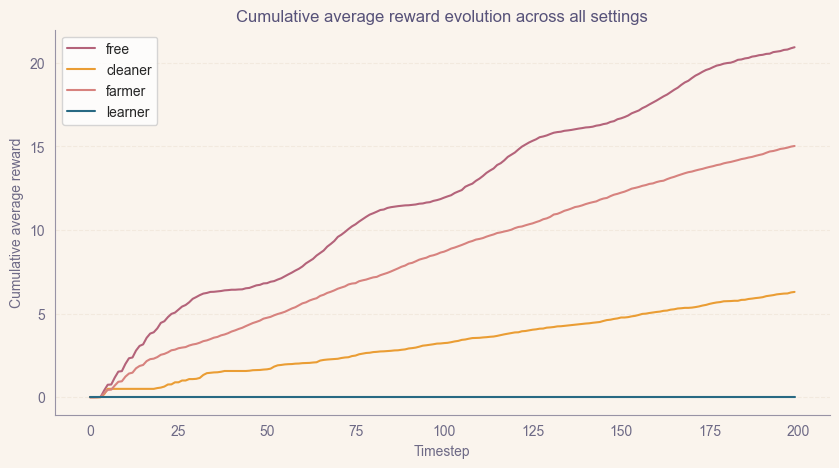

In [556]:
# data is stored in a list of 32 lists called `data_list`
averages = []
for i in range(10):
    #fig, ax = plt.subplots(figsize=(8,6))
    mean_rewards = pd.DataFrame() # Initialize an empty DataFrame to store the mean rewards for the current setting
    for j in range(13):
        df = baseline_dfs[i][j] # Get the j-th dataframe for the i-th setting
        rewards = df.iloc[:, 1:5] # Get the first 4 columns (rewards per timestep)
        mean_rewards = mean_rewards.add(rewards, fill_value=0) # Add the rewards to the running sum in mean_rewards
    mean_rewards = mean_rewards.divide(13) # Divide the sum by the number of dataframes (8) to get the mean
    mean_rewards_cum = mean_rewards.cumsum() # Compute the cumulative mean rewards
    cur_rules = settings_names.iloc[i, 3].split(", ")
    rule_out = '\n'.join([str(elem) for elem in cur_rules])
    info_text = f"Active rules: {len(cur_rules)}\n {rule_out}"
    #ax.text(0.5, -0.1, info_text, ha="center", transform=fig.transFigure, fontsize=10,
         #bbox=dict(facecolor='white', alpha=0.5, boxstyle="round"))
    averages.append(mean_rewards) # Add the mean rewards to the list of averages for all settings
    #ax.plot(mean_rewards_cum) # Plot the cumulative mean reward evolution for the current setting
    #ax.set_title(f"Cumulative average reward evolution for setting {i+1}")
    #ax.set_xlabel("Timestep")
    #ax.set_ylabel("Cumulative average reward")
    #ax.legend(labels=mean_rewards.columns) # Add a legend with the column names
    #plt.show()
    
# Plot the average rewards across all settings
#fig, ax = plt.subplots(figsize=(8,6))
average_rewards = pd.concat(averages).groupby(level=0).mean() # Concatenate all mean rewards and compute the average across all settings
average_rewards_cum = average_rewards.cumsum() # Compute the cumulative average rewards

# Plot each dimension with a different color
for i, col in enumerate(average_rewards_cum.columns):
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.plot(average_rewards_cum[col])

#plt.plot(average_rewards_cum, c=colors) # Plot the cumulative average reward evolution for all settings
plt.title("Cumulative average reward evolution across all settings")
plt.xlabel("Timestep")
plt.ylabel("Cumulative average reward")
plt.legend(labels=average_rewards.columns) # Add a legend with the column names
plt.savefig('cum_rewards')
plt.show()

## 2. Test on active agents

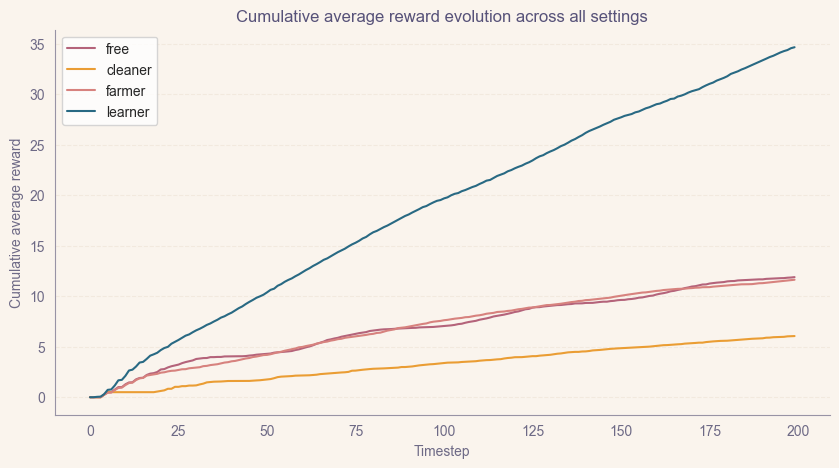

In [557]:
# data is stored in a list of 32 lists called `data_list`
averages = []
for i in range(8):
    #fig, ax = plt.subplots(figsize=(8,6))
    mean_rewards = pd.DataFrame() # Initialize an empty DataFrame to store the mean rewards for the current setting
    for j in range(13):
        df = test_dfs[i][j] # Get the j-th dataframe for the i-th setting
        rewards = df.iloc[:, 1:5] # Get the first 4 columns (rewards per timestep)
        mean_rewards = mean_rewards.add(rewards, fill_value=0) # Add the rewards to the running sum in mean_rewards
    mean_rewards = mean_rewards.divide(13) # Divide the sum by the number of dataframes (8) to get the mean
    mean_rewards_cum = mean_rewards.cumsum() # Compute the cumulative mean rewards
    cur_rules = settings_names.iloc[i, 3].split(", ")
    rule_out = '\n'.join([str(elem) for elem in cur_rules])
    info_text = f"Active rules: {len(cur_rules)}\n {rule_out}"
    #ax.text(0.5, -0.1, info_text, ha="center", transform=fig.transFigure, fontsize=10,
         #bbox=dict(facecolor='white', alpha=0.5, boxstyle="round"))
    averages.append(mean_rewards) # Add the mean rewards to the list of averages for all settings
    #ax.plot(mean_rewards_cum) # Plot the cumulative mean reward evolution for the current setting
    #ax.set_title(f"Cumulative average reward evolution for setting {i+1}")
    #ax.set_xlabel("Timestep")
    #ax.set_ylabel("Cumulative average reward")
    #ax.legend(labels=mean_rewards.columns) # Add a legend with the column names
    #plt.show()
    
average_rewards = pd.concat(averages).groupby(level=0).mean() # Concatenate all mean rewards and compute the average across all settings
average_rewards_cum = average_rewards.cumsum() # Compute the cumulative average rewards

# Plot each dimension with a different color
for i, col in enumerate(average_rewards_cum.columns):
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.plot(average_rewards_cum[col])

#plt.plot(average_rewards_cum, c=colors) # Plot the cumulative average reward evolution for all settings
plt.title("Cumulative average reward evolution across all settings")
plt.xlabel("Timestep")
plt.ylabel("Cumulative average reward")
plt.legend(labels=average_rewards.columns) # Add a legend with the column names
plt.savefig('cum_rewards')
plt.show()

## 2. Test on Rule Sets

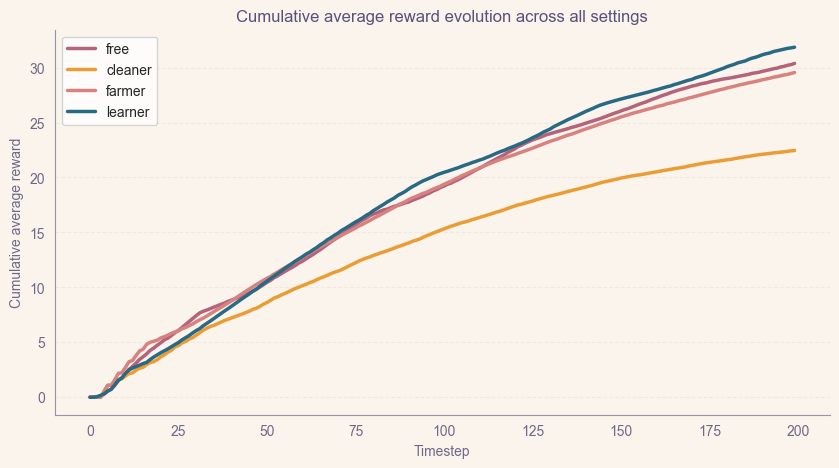

In [558]:
# data is stored in a list of 32 lists called `data_list`
averages = []
for i in range(32):
    #fig, ax = plt.subplots(figsize=(8,6))
    mean_rewards = pd.DataFrame() # Initialize an empty DataFrame to store the mean rewards for the current setting
    for j in range(13):
        df = rules_dfs[i][j] # Get the j-th dataframe for the i-th setting
        rewards = df.iloc[:, 1:5] # Get the first 4 columns (rewards per timestep)
        mean_rewards = mean_rewards.add(rewards, fill_value=0) # Add the rewards to the running sum in mean_rewards
    mean_rewards = mean_rewards.divide(12) # Divide the sum by the number of dataframes (8) to get the mean
    mean_rewards_cum = mean_rewards.cumsum() # Compute the cumulative mean rewards
    #cur_rules = settings_names.iloc[i, 3].split(", ")
    #rule_out = '\n'.join([str(elem) for elem in cur_rules])
    #info_text = f"Active rules: {len(cur_rules)}\n {rule_out}"
    #ax.text(0.5, -0.1, info_text, ha="center", transform=fig.transFigure, fontsize=10,
         #bbox=dict(facecolor='white', alpha=0.5, boxstyle="round"))
    averages.append(mean_rewards) # Add the mean rewards to the list of averages for all settings
    #ax.plot(mean_rewards_cum) # Plot the cumulative mean reward evolution for the current setting
    #ax.set_title(f"Cumulative average reward evolution for setting {i+1}")
    #ax.set_xlabel("Timestep")
    #ax.set_ylabel("Cumulative average reward")
    #ax.legend(labels=mean_rewards.columns) # Add a legend with the column names
    #plt.show()
    
# Plot the average rewards across all settings
# fig, ax = plt.subplots(figsize=(8,6))
average_rewards = pd.concat(averages).groupby(level=0).mean() # Concatenate all mean rewards and compute the average across all settings
average_rewards_cum = average_rewards.cumsum() # Compute the cumulative average rewards

# Plot each dimension with a different color
for i, col in enumerate(average_rewards_cum.columns):
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.plot(average_rewards_cum[col], linewidth=2.5)


# bulk-set the properties of all lines and texts
plt.title("Cumulative average reward evolution across all settings")
plt.xlabel("Timestep")
plt.ylabel("Cumulative average reward")
plt.legend(labels=average_rewards.columns) # Add a legend with the column names
plt.savefig('cum_rewards')
plt.show()

# 1. Learned Rules

In [559]:
PROHIBITIONS = [
    "obs['NUM_APPLES_AROUND'] < 3 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION",
    "obs['CUR_CELL_HAS_APPLE'] and not obs['AGENT_HAS_STOLEN'] -> !MOVE_ACTION"
]
OBLIGATION_CLEANER = [
    "obs['SINCE_AGENT_LAST_CLEANED'] > 5 -> obs['SINCE_AGENT_LAST_CLEANED'] < 5"
]
OBLIGATION_FARMER = [
    "obs['SINCE_AGENT_LAST_PAYED'] > 15 -> obs['SINCE_AGENT_LAST_PAYED'] < 15"
]
OBLIGATION_FREE = [
    "obs['SINCE_AGENT_LAST_CLEANED'] > 30 -> obs['SINCE_AGENT_LAST_CLEANED'] < 30"
]
ACTIVE_RULES_PER_ROLE = [
    [],
    PROHIBITIONS + OBLIGATION_FREE,
    PROHIBITIONS + OBLIGATION_CLEANER,
    PROHIBITIONS,
    PROHIBITIONS + OBLIGATION_FREE + OBLIGATION_CLEANER,
    PROHIBITIONS + OBLIGATION_FREE ,
    PROHIBITIONS + OBLIGATION_FARMER + OBLIGATION_CLEANER,
    PROHIBITIONS + OBLIGATION_FARMER + OBLIGATION_CLEANER + OBLIGATION_FREE
]

In [560]:
def get_active_rules(i: int, setting: str):
    if setting == 'rules':
        return [rule for rule in settings_lambda.iloc[i, 3].strip("(").strip(")").split(", ")]
    elif setting == 'test':
        return ACTIVE_RULES_PER_ROLE[i]
    return

In [561]:
num_settings = 32
num_trials = 13
target_percentages = [0.2, 0.4, 0.6, 0.8, 0.99]
target_timesteps = [20, 40, 80, 100, 120]
num_timesteps = len(target_percentages)

In [562]:
def count_classification(active_rules, setting, percentage, timestep, percentages_all, timesteps):
    for trial in range(num_trials):
        # Get the percentages of rules learned for this setting and trial
        percentages = percentages_all[setting][trial]
        
        # Iterate over each percentage and timestep to count for
        for percentage in target_percentages:
            for timestep in target_timesteps:
                # Find the index of the timestep in the list of timesteps
                timestep_index = timesteps.index(timestep)

                # Find the index of the percentage in the list of percentages
                for i, p in enumerate(percentages):
                    if p >= percentage:
                        percentage_index = i
                        break

                true_positives_active = 0
                false_negatives_active = 0
                true_positives_nonactive = 0
                false_negatives_nonactive = 0
                
                for rule in active_rules:
                    if df.loc[timestep, rule] >= percentage:
                        true_positives_active += 1
                    else:
                        false_negatives_active += 1
                        
                for column in df.columns:
                    if column not in active_rules:
                        if df.loc[timestep, column] < percentage:
                            true_positives_nonactive += 1
                        else:
                            false_negatives_nonactive += 1

In [563]:
def extract_timesteps(input_df: pd.DataFrame, num_settings: int, setting_str: str,
                      target_percentages: list, target_timesteps: list):
    results = []
    for i in range(num_settings):
        for j in range(13):
            # Load the corresponding dataframe
            df = input_df[i][j]

            active_rules = get_active_rules(i, setting_str)
            if "" in active_rules:
                active_rules.remove("")
                
            # Extract only the active rules from the dataframe
            df_active = df[active_rules]

            num_active = len(active_rules)

            # Step 2: Calculate the timesteps where the agent has learned 50%, 80%, and 100% of the rules
            learned = []
            for row in df_active.itertuples():
                if not len(df_active.columns) == 0:
                    learned.append(sum(row[1:]) / len(df_active.columns))
                else:
                    learned.append(sum(row[1:]))

            timesteps = []
            for target in target_percentages:
                flag = False
                for idx, percent in enumerate(learned):
                    if percent >= target:
                        timesteps.append(idx)
                        flag = True
                        break
                if flag == False:
                    timesteps.append(np.nan)

            # Step 3: Calculate the percentage of rules learned at timesteps 10, 30, and 50
            percentages = []
            for target in target_timesteps:
                if not len(df_active.columns) == 0:
                    percentages.append(sum(df_active.iloc[target]) / len(df_active.columns))

                else:
                    percentages.append(sum(df_active.iloc[target]))

            # Step 4: Store the results for this setting and trial
            results.append({'setting': i, 'trial': j, 'discrete_timesteps': timesteps, 
                            'discrete_percentages': percentages, 'all_values': learned,
                            'num_active_rules': num_active})

    return results

In [564]:
def extract_rules(input_df: pd.DataFrame, num_settings: int, rules: list, setting_str: str):
    results = []
    for i in range(num_settings):
        for j in range(13):
            # Load the corresponding dataframe
            df = input_df[i][j]

            active_rules = get_active_rules(i, setting_str)
            if "" in active_rules:
                active_rules.remove("")

            for idx, rule in enumerate(rules):
                # Extract only the active rules from the dataframe
                df_active = df[[rule]]

                learned = []
                for row in df_active.itertuples():
                    if not rule in active_rules:
                        learned.append(np.nan)
                    else:
                        if not len(df_active.columns) == 0:
                            learned.append(sum(row[1:]) / len(df_active.columns))
                        else:
                            learned.append(sum(row[1:]))

                # Step 4: Store the results for this setting and trial
                results.append({'setting': i, 'trial': j, 'rule': rule, 'rule_idx': idx, 'all_values': learned})

    return results

In [565]:
def get_f1_score():
    tp_act_total, fn_act_total, tp_nonact_total, fn_nonact_total = 0, 0, 0, 0
    for percentage in percentages:
        for timestep in timesteps:
            tp_act, fn_act, tp_nonact, fn_nonact = count_classification(active_rules, setting, percentage, timestep, percentages_all, timesteps)
            cur_tp_act_sum += tp_act
            cur_fn_act_sum += fn_act
            cur_tp_nonact_sum += tp_nonact
            cur_fn_nonact_sum += fn_nonact
        
        num_combinations = len(percentages) * len(timesteps) * num_trials
        avg_tp_act = cur_tp_act_sum / num_combinations
        avg_fn_act = cur_fn_act_sum / num_combinations
        avg_tp_nonact = cur_tp_nonact_sum / num_combinations
        avg_fn_nonact = cur_fn_nonact_sum / num_combinations

        # Print the results
        print(f'Setting {setting+1}:')
        print(f'Active rules TP: {avg_tp_act}')
        print(f'Non-active rules TP: {avg_tp_nonact}')
        print(f'Active rules FN: {avg_fn_act}')
        print(f'Non-active rules FN: {avg_fn_nonact}')

In [566]:
TEST_SETTING_NAME = [
    "Leaner",
    "Free + learner",
    "Cleaner + learner",
    "Farmer + learner",
    "Cleaner, free + learner",
    "Farmer, free + learner",
    "Cleaner, farmer + learner",
    "Cleaner, farmer, free + learner",
]

In [567]:
def get_setting_name(i: int, setting_str: str):
    if setting_str == 'test':
        return TEST_SETTING_NAME[i]
    else:
        return settings_names.iloc[i, 3].split(", ")

In [568]:
def plot_timestep_per_percentage(num_settings: int, timesteps_all: list, target_percentages: list, setting_str: str):
    for setting in range(num_settings):
        setting_timesteps = np.array(timesteps_all[setting])
        mean_timesteps = np.nanmean(setting_timesteps, axis=0)
        std_timesteps = np.std(setting_timesteps, axis=0)
        setting_name = get_setting_name(setting, setting_str)
        # Plot the mean and standard deviation of percentages
        plt.errorbar(target_percentages, mean_timesteps, yerr=std_timesteps, label=f'{setting_name}', c=colors[setting], linewidth=2.5)

    plt.legend()
    plt.xlabel('Percentage')
    plt.ylabel('Timestep of Rule Reached Percentage')
    plt.title('Timesteps where Rule Posterior has reached Percentage for Different Settings')
    plt.show()

In [569]:
def plot_percentage_per_timestep(num_settings: int, percentages_all: list, target_timesteps: list, setting_str: str):
    for setting in range(num_settings):
        setting_percentages = np.array(percentages_all[setting])
        mean_percentages = np.nanmean(setting_percentages, axis=0)
        std_percentages = np.std(setting_percentages, axis=0)
        setting_name = get_setting_name(setting, setting_str)
        plt.errorbar(target_timesteps, mean_percentages, yerr=std_percentages, label=f'{setting_name}', linewidth=2.5)

    plt.legend()
    plt.xlabel('Timestep')
    plt.ylabel('Percentage of Rules Learned')
    plt.title('Percentage of Rules Learned for Different Settings')
    plt.show()

In [570]:
def plot_percentage_per_all_timesteps( all_values: list, setting_str: str):
    for setting in range(len(all_values)):
        setting_timesteps = np.array(all_values[setting])
        mean_percentages = np.nanmean(setting_timesteps, axis=0)
        setting_name = get_setting_name(setting, setting_str)

        plt.errorbar(mean_percentages, [*range(len(mean_percentages))], label=f'{setting_name}', linewidth=2.5)

    plt.legend()
    plt.xlabel('Timestep')
    plt.ylabel('Percentage of Rules Learned')
    plt.title('Percentage of Rules Learned for Different Settings')
    plt.show()

In [571]:
def plot_all_timesteps_per_percentage(all_values: list, setting_str: str):
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(12,6))
        for setting in range(len(all_values)):
            setting_timesteps = np.array(all_values[setting])
            mean_timesteps = np.nanmean(setting_timesteps, axis=0)
            setting_name = get_setting_name(setting, setting_str)
            plt.errorbar([*range(len(mean_timesteps))], mean_timesteps, label=f'{setting_name}', linewidth=2.5)

    plt.legend()
    plt.xlabel('Timestep')
    plt.ylabel('Percentage')
    plt.title('Rule Posterior per Timesteps where for Different Settings')
    plt.show()

In [572]:
RULE_NAME_DICT = {
    "obs['NUM_APPLES_AROUND'] < 3 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Prohibition: Don't collect apple if less than 3 apples around",
    "obs['CUR_CELL_HAS_APPLE'] and not obs['AGENT_HAS_STOLEN'] -> !MOVE_ACTION": "Prohibition: Don't collect apple if it's on forgein territory",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 5 -> obs['SINCE_AGENT_LAST_CLEANED'] < 5": "Obligation: If you're in the cleeaner role, clean every 5 steps",
    "obs['SINCE_AGENT_LAST_PAYED'] > 15 -> obs['SINCE_AGENT_LAST_PAYED'] < 15": "Obligation: If you're in the farmer role, pay your cleaner every 15 steps",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 30 -> obs['SINCE_AGENT_LAST_CLEANED'] < 30": "Obligation: If you're in the free role, clean every 30 steps"
}

In [573]:
def get_rule_name(rule):
    return RULE_NAME_DICT[rule]

In [585]:
def plot_single_rule_learning(rules: list, all_values: list, setting_str: str):
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(10,4))
        for idx, rule in enumerate(rules):
            rule_name = get_rule_name(rule)

            # Assuming your array is named 'data'
            averaged_data = np.nanmean(all_values[idx], axis=(0, 1))
            plt.plot(averaged_data, label=rule_name, linewidth=2.5)

    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Timestep')
    plt.ylabel('Percentage of Rules Learned')
    plt.title('Percentage of Rules Learned per Rule')
    plt.show()

In [ ]:
ALL_RULES = PROHIBITIONS + OBLIGATION_FARMER + OBLIGATION_CLEANER + OBLIGATION_FREE

In [917]:
def plot_rule_after_timestep_x(all_values: list, timestep: int):

    labels = ['P1', 'P2', 'O1', 'O2', 'O3']
    colors = ['pink', 'lightblue', 'lightgreen', 'lightblue', 'pink']

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(10, 4))
        boxplot_data = [[] for _ in range(5)]
        for idx in range(len(ALL_RULES)):
            data = []
            for i in range(len(all_values[idx])):
                for j in range(len(all_values[idx][0])):
                    data.append(all_values[idx][i][j][timestep])
            cleandata= [x for x in data if str(x) != 'nan']
            boxplot_data[idx] = cleandata

        plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
        
    plt.xlabel('Timestep')
    plt.ylabel('Percentage of Rules Learned')
    plt.title('Percentage of Rules Learned per Rule')
    plt.show()


## Settings

In [918]:
num_trials = 13
num_timesteps = 5
target_percentages = [0.2, 0.4, 0.6, 0.8, 0.99]
target_timesteps = [20, 40, 80, 100, 120]

## 1. Test on Rules

In [919]:
num_settings = 32
setting_str = 'rules' # 'rules' or 'test'

timestep_results = extract_timesteps(rules_dfs, num_settings=num_settings, setting_str=setting_str,
                target_percentages=target_percentages, target_timesteps=target_timesteps)

single_rule_results = extract_rules(rules_dfs, num_settings=num_settings, rules=ALL_RULES, setting_str=setting_str)

percentages_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
timesteps_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_timesteps = [[[] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_rules = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(ALL_RULES))]

for result in timestep_results:
    setting = result['setting']
    trial = result['trial']
    timesteps = result['discrete_timesteps']
    percentages = result['discrete_percentages']
    all_values = result['all_values']
    continuous_timesteps[setting][trial] = all_values
    
    for i in range(num_timesteps):
        timestep = i
        timesteps_all[setting][trial][timestep] = timesteps[i]
        percentages_all[setting][trial][timestep] = percentages[i]

continuous_timesteps_1 = continuous_timesteps[:5]
continuous_timesteps_2 = continuous_timesteps[5:15]
continuous_timesteps_3 = continuous_timesteps[15:26]
continuous_timesteps_4 = continuous_timesteps[26:]

for result in single_rule_results:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules[rule_idx][setting][trial] = all_values


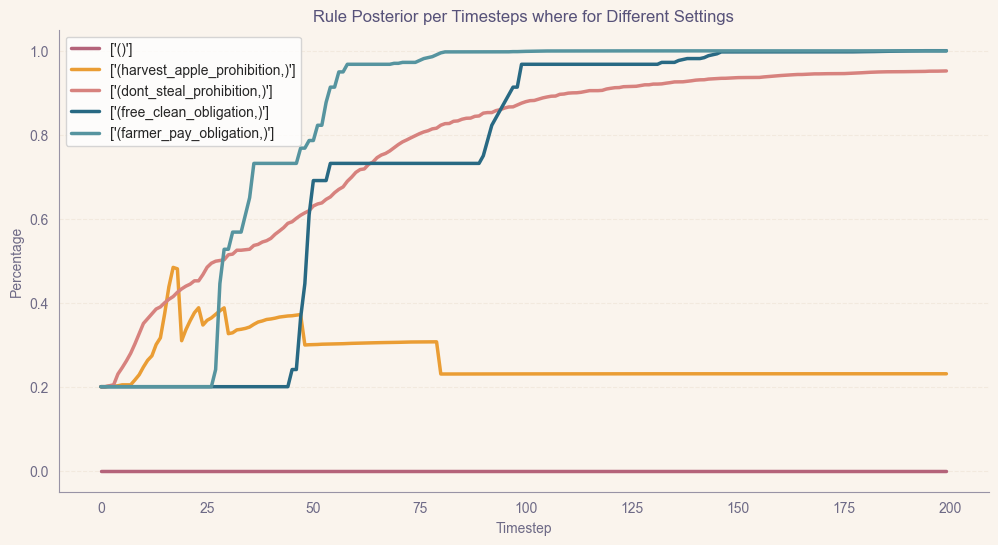

In [920]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_1, setting_str=setting_str
)

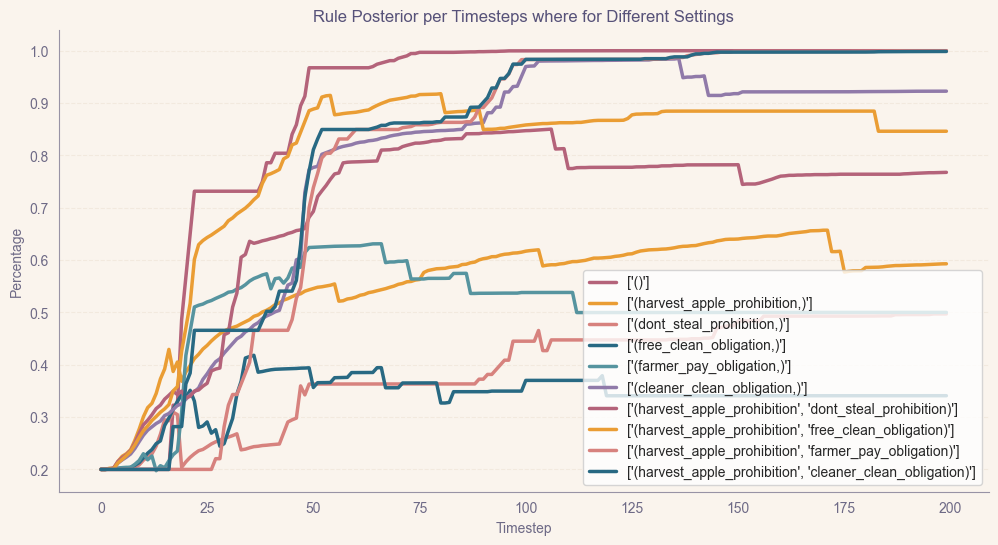

In [921]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_2, setting_str=setting_str
)

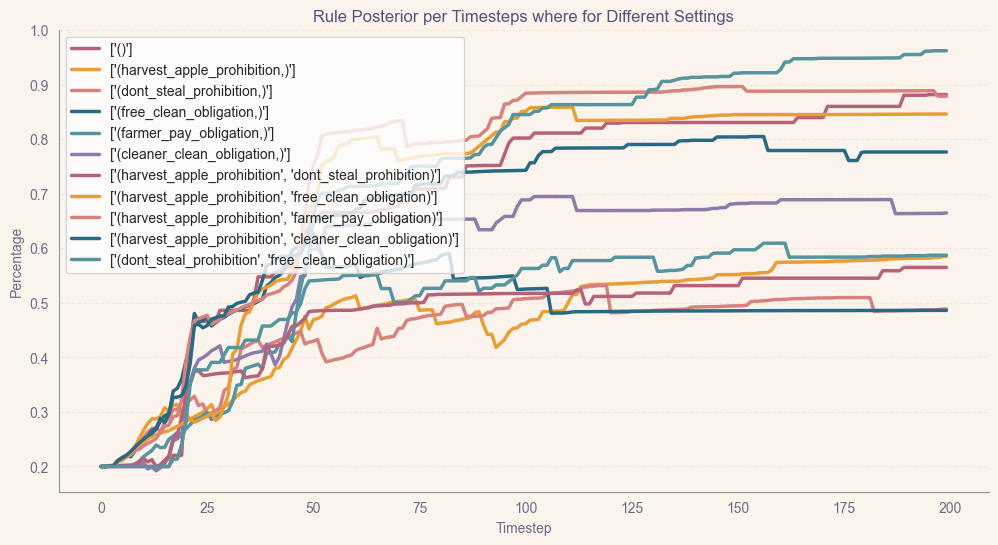

In [922]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_3, setting_str=setting_str
)

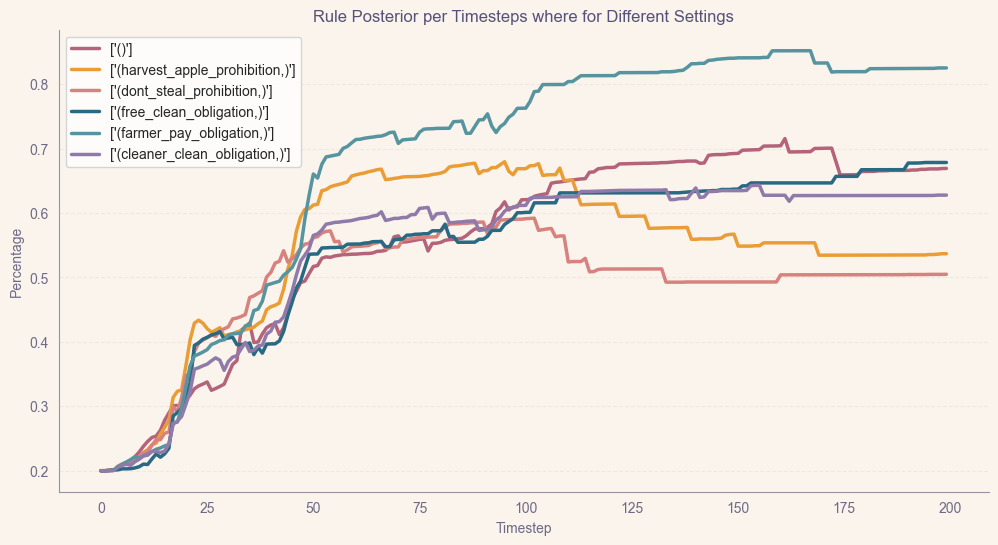

In [923]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_4, setting_str=setting_str
)

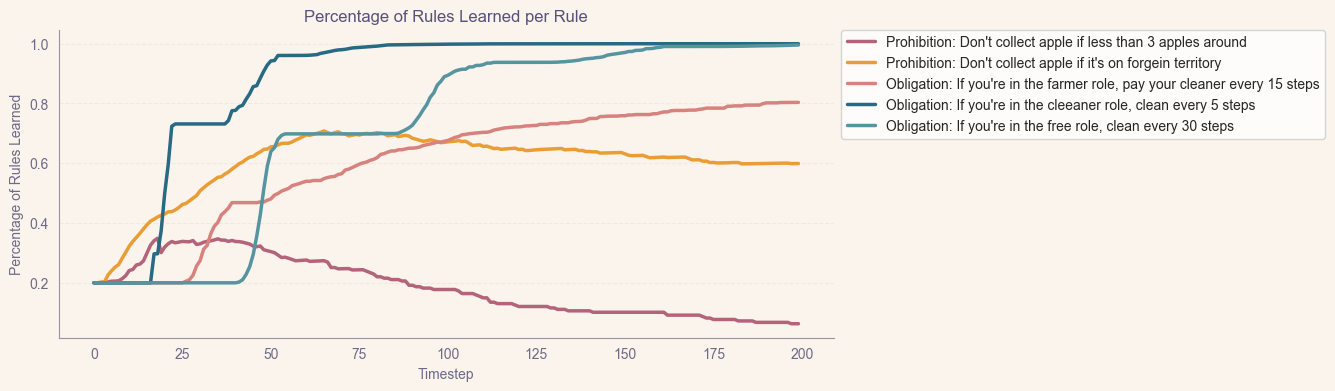

In [924]:
plot_single_rule_learning(
    rules=ALL_RULES, all_values=continuous_rules, setting_str=setting_str
)

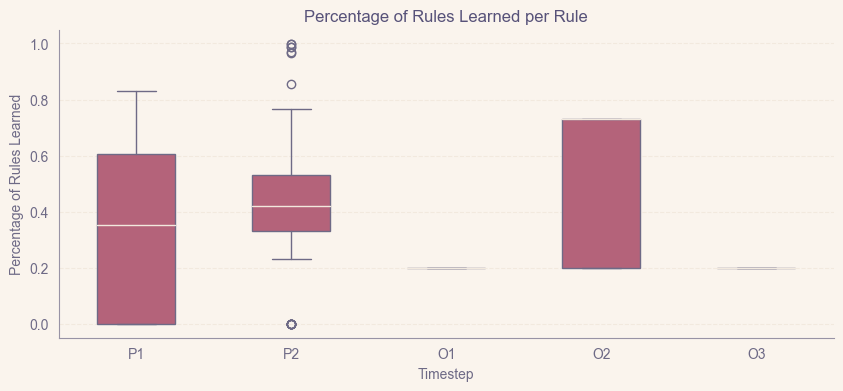

In [935]:
# data must be formatted s.t. data[timestep] is all data for one timestep
plot_rule_after_timestep_x(all_values=continuous_rules, timestep=20)

## 2. Test on Roles

In [582]:
num_settings = 8
setting_str = 'test' # 'rules' or 'test'

results = extract_timesteps(rules_dfs, num_settings=num_settings, setting_str=setting_str,
                target_percentages=target_percentages, target_timesteps=target_timesteps)

ALL_RULES = PROHIBITIONS + OBLIGATION_FARMER + OBLIGATION_CLEANER + OBLIGATION_FREE
single_rule_results = extract_rules(rules_dfs, num_settings=num_settings, rules=ALL_RULES, setting_str=setting_str)

percentages_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
timesteps_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_timesteps = [[[] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_rules = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(ALL_RULES))]

for result in results:
    setting = result['setting']
    trial = result['trial']
    timesteps = result['discrete_timesteps']
    percentages = result['discrete_percentages']
    all_values = result['all_values']
    continuous_timesteps[setting][trial] = all_values
    
    for i in range(num_timesteps):
        timestep = i
        timesteps_all[setting][trial][timestep] = timesteps[i]
        percentages_all[setting][trial][timestep] = percentages[i]

for result in single_rule_results:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules[rule_idx][setting][trial] = all_values

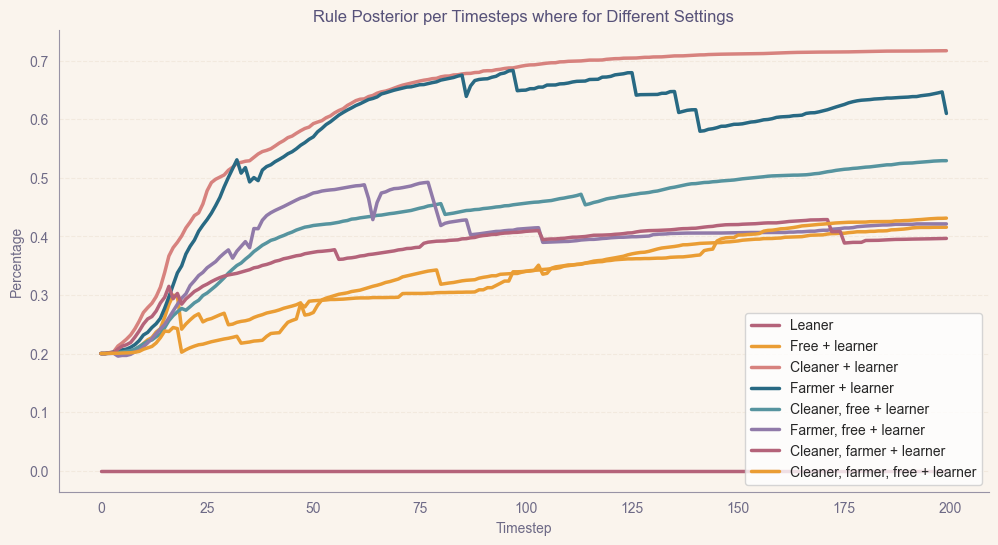

In [583]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps, setting_str=setting_str
)

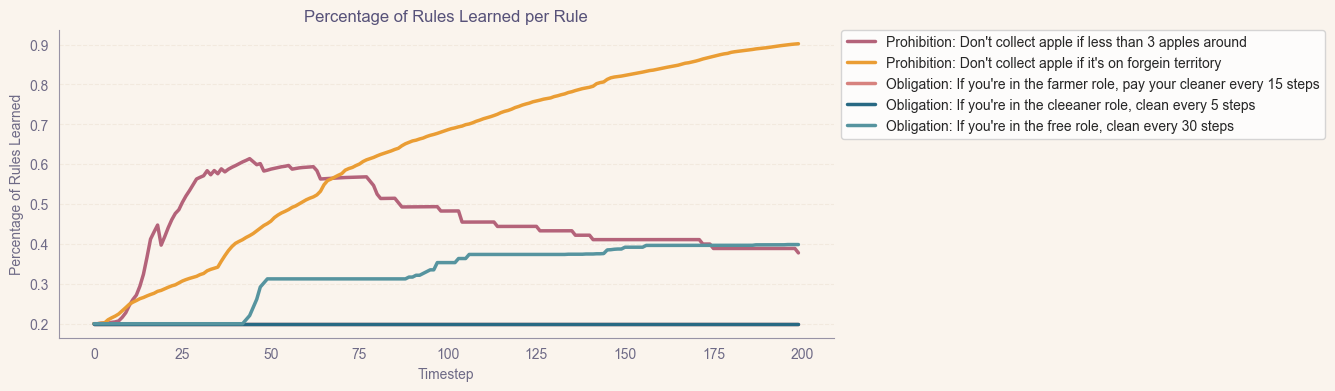

In [584]:
plot_single_rule_learning(
    rules=ALL_RULES, all_values=continuous_rules, setting_str=setting_str
)

## Other plots (commented out)

In [169]:
"""plot_timestep_per_percentage(
    num_settings=num_settings, timesteps_all=timesteps_all, target_percentages=target_percentages
)

plot_percentage_per_timestep(
    num_settings=num_settings, percentages_all=percentages_all, target_timesteps=target_timesteps
)

plot_percentage_per_all_timesteps(
    num_settings=num_settings, all_values=continuous_timesteps
)"""

'plot_timestep_per_percentage(\n    num_settings=num_settings, timesteps_all=timesteps_all, target_percentages=target_percentages\n)\n\nplot_percentage_per_timestep(\n    num_settings=num_settings, percentages_all=percentages_all, target_timesteps=target_timesteps\n)\n\nplot_percentage_per_all_timesteps(\n    num_settings=num_settings, all_values=continuous_timesteps\n)'